In [1]:
import os
import glob
import pickle
import pandas as pd
from tqdm.notebook import tqdm

data_dir = "data"
xls_dir = "xls"

## Save data to pickle files

In [ ]:
raw_prefix = "test"
processed_prefix = "ind"


xls_paths = glob.glob(os.path.join(xls_dir, "*.xls"))

os.makedirs(data_dir, exist_ok=True)

raw = list(dict())
processed = list(dict())

for i, file_path in enumerate(tqdm(xls_paths, desc="Files")):
    xls_file = pd.ExcelFile(file_path)
    xls_file_id = int(file_path.split('.')[0][-1])
    sheet_names = [sheet_name for sheet_name in xls_file.sheet_names if sheet_name.lower().startswith((raw_prefix, processed_prefix))]
    for sheet_name in tqdm(sheet_names, desc="Sheets", leave=False):
        try:
            sheet_id = int(sheet_name[-3:])
            if sheet_name.lower().startswith(raw_prefix):
                sample_df = pd.read_excel(file_path, sheet_name=sheet_name, header=0, skiprows=[1])
                info = pd.DataFrame({'xls_file_id':[xls_file_id], 'sheet_id': [sheet_id]})
                data = sample_df.iloc[1:].reset_index(drop=True)
                raw.append({"info": info, "data": data})
            elif sheet_name.lower().startswith(processed_prefix):
                sample_df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
                info = sample_df.iloc[0, -11:].to_frame().T
                info.insert(0, 'xls_file_id', xls_file_id)
                info.insert(1, 'sheet_id', sheet_id)
                data = sample_df.iloc[1:].reset_index(drop=True)
                processed.append({"info": info, "data": data})
        except ValueError:
            print(f"Skipping sheet {sheet_name} in file {file_path}")
            pass


with open(f'{data_dir}/processed.pkl', 'wb') as f:
    pickle.dump(processed, f)

with open(f'{data_dir}/raw.pkl', 'wb') as f:
    pickle.dump(raw, f)

## Open Raw & Processed Files

In [2]:
with open(f'{data_dir}/processed.pkl', 'rb') as f:
    processed = pickle.load(f)
    processed_info = [p['info'] for p in processed]
    processed_dfs = [p['data'] for p in processed]

with open(f'{data_dir}/raw.pkl', 'rb') as f:
    raw = pickle.load(f)
    raw_info = [r['info'] for r in raw]
    raw_dfs = [r['data'] for r in raw]

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def get_processed_features(df_list, scaler=None):
    features_list = []
    for dataframe in df_list:
        df = dataframe.copy()
        if df.shape[0] < 1000:
            pass
        else:
            df = df.iloc[:, 1:-11]
            df = df[df[df.columns[5]] >= 0]
            df = df.drop(columns=[df.columns[3]])
            col_name = df.columns[4]
            col = df.pop(col_name)
            df.insert(0, col_name, col)
            df = df.drop_duplicates(keep=False)
            columns = df.columns.tolist()
            df = scaler.fit_transform(df) if scaler is not None else df
            features_list.append(pd.DataFrame(df, columns=columns))
    return features_list

def get_raw_features(df_list, scaler=None):
    features_list = []
    for dataframe in df_list:
        df = dataframe.copy()
        if df.shape[0] < 1000:
            pass
        else:
            df = df.iloc[:, 1:-6]
            df = df[df[df.columns[0]] >= 0]
            df = df.drop_duplicates(keep=False)
            columns = df.columns.tolist()
            df = scaler.fit_transform(df) if scaler is not None else df
            features_list.append(pd.DataFrame(df, columns=columns))
    return features_list

processed_feature_dfs = get_processed_features(processed_dfs, scaler)
raw_feature_dfs = get_raw_features(raw_dfs, scaler)

In [4]:
processed_feature_dfs[0]

,Déplacement corrigé dérive thermique (nm),Force (mN),Raideur brute (N/m),P/S² (nm),Amortissement brut,Raideur de contact (N/m),hr (nm),ErL(MPa),HL (MPa),EL (MPa),hcOP (nm),ErOP(MPa),HOP (MPa),EOP (MPa),ErsL(MPa),ErsOP(MPa),tan delta
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.002297,0.000000,0.000000,0.000000,0.001560,0.000000,0.000000,0.000000,0.261674,0.264604,1.000000
1,0.000293,4.524105e-07,0.000020,0.000291,0.586429,0.000018,0.001759,0.001346,0.001949,0.001134,0.001240,0.001325,0.001985,0.001079,0.276047,0.276277,0.536991
2,0.000426,1.792545e-06,0.000042,0.000422,1.000000,0.000037,0.000540,0.003159,0.009394,0.002663,0.000376,0.003009,0.009022,0.002450,0.305203,0.299361,0.370752
3,0.000513,3.166250e-06,0.000065,0.000508,0.936570,0.000058,0.000000,0.005124,0.018218,0.004320,0.000000,0.004821,0.016966,0.003928,0.329010,0.319047,0.286850
4,0.000799,3.676547e-06,0.000095,0.000792,0.606116,0.000083,0.000684,0.006817,0.018808,0.005750,0.000580,0.006526,0.017901,0.005319,0.331562,0.323987,0.229738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,0.988537,9.775689e-01,0.978303,0.988435,0.001770,0.975505,0.987632,0.928961,0.718734,0.916782,0.987868,0.928378,0.730930,0.913431,0.482597,0.483110,0.004065
1601,0.991290,9.834526e-01,0.984578,0.991217,0.001756,0.982575,0.990652,0.932879,0.718709,0.921315,0.990818,0.932360,0.731008,0.918171,0.436582,0.437020,0.003666
1602,0.994335,9.893362e-01,0.990901,0.994289,0.001741,0.989711,0.993986,0.936543,0.718220,0.925560,0.994077,0.936094,0.730624,0.922624,0.409794,0.410197,0.003431
1603,0.997557,9.952196e-01,0.996655,0.997536,0.001728,0.996215,0.997464,0.939451,0.717518,0.928932,0.997488,0.939064,0.730009,0.926170,0.402266,0.402673,0.003360


<Axes: >

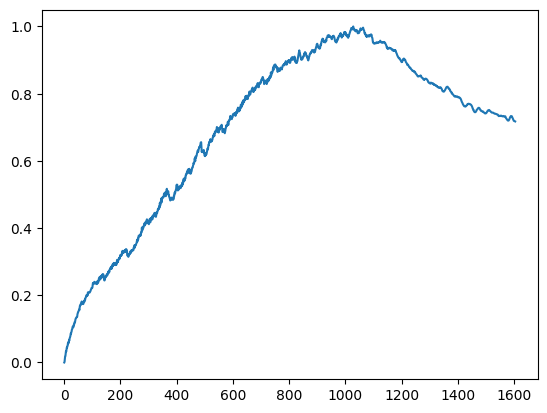

In [5]:
processed_feature_dfs[0].iloc[:, 8].plot()

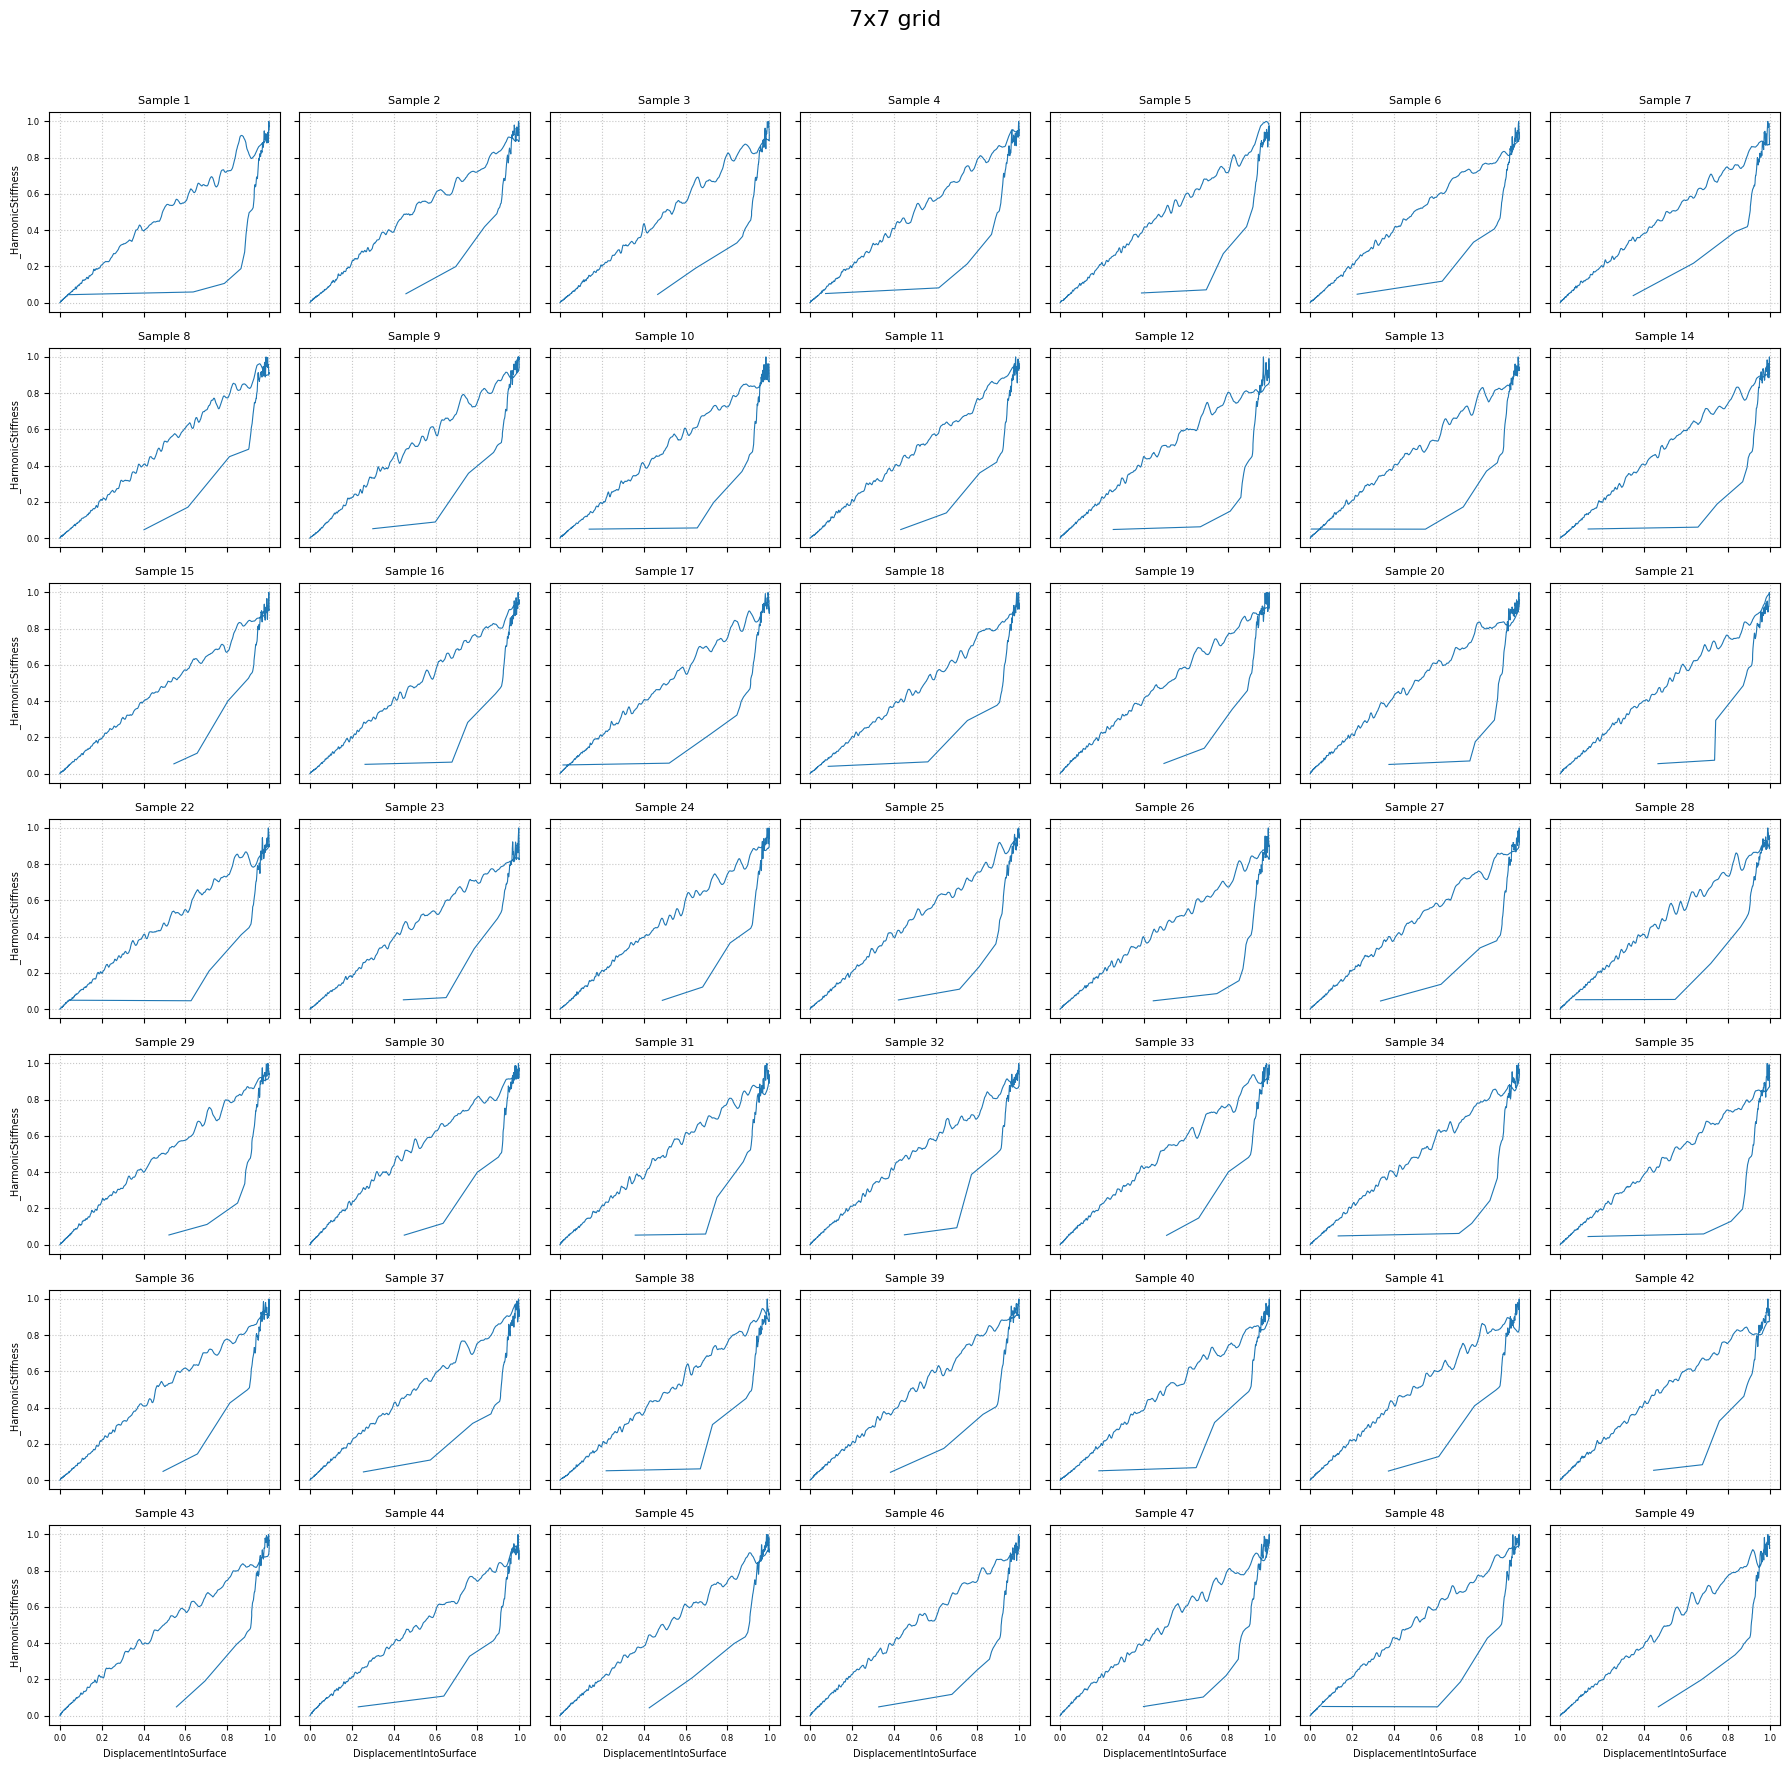

In [6]:
import matplotlib.pyplot as plt

RAW_DISPLACEMENT_COL = 'DisplacementIntoSurface'
RAW_LOAD_COL = '_HarmonicStiffness' 

grid_size = (7, 7)
num_plots = grid_size[0] * grid_size[1]

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(18, 18), sharex=True, sharey=True)
fig.suptitle(f'{grid_size[0]}x{grid_size[1]} grid', fontsize=16)
axes_flat = axes.flatten()

for i in range(min(len(raw_feature_dfs), num_plots)):
    df = raw_feature_dfs[i]
    ax = axes_flat[i]
        
    ax.plot(df[RAW_DISPLACEMENT_COL], df[RAW_LOAD_COL], linewidth=0.8)
    ax.set_title(f'Sample {i+1}', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

    if i // grid_size[1] == grid_size[0] - 1: 
        ax.set_xlabel(RAW_DISPLACEMENT_COL, fontsize=7)
    if i % grid_size[1] == 0: 
        ax.set_ylabel(RAW_LOAD_COL, fontsize=7)
    ax.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()